In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

from pathlib import Path
import json
import yaml

import procgen

from IPython.display import clear_output

2023-04-13 18:42:45.077854: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


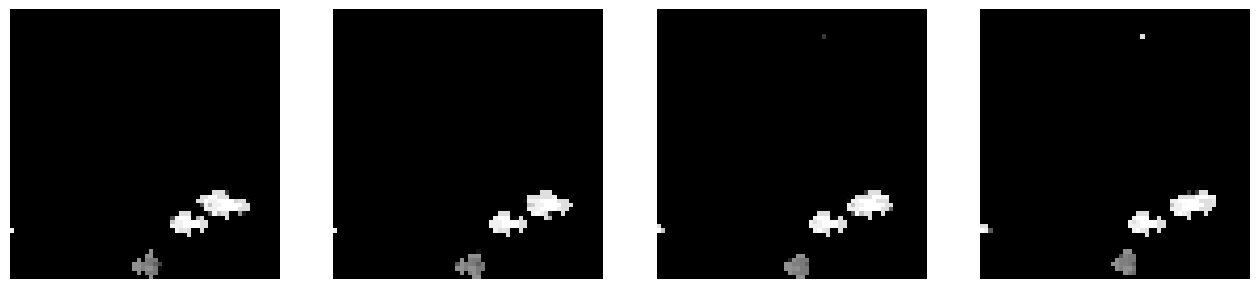

In [665]:
import gym
import cv2
from mlrl.utils.env_wrappers import ImagePreprocessWrapper, FrameStack
from tf_agents.environments import ActionRepeat

def create_stacked_coinrun_env(frame_skip=0, frame_stack=4):
    base_env = gym.make('procgen-bigfish-v0',
                        use_backgrounds=False,
                        restrict_themes=True,
                        distribution_mode='easy')
    gym_wrapped = GymWrapper(base_env)
    gym_wrapped._action_is_discrete = False  # gym wrapper takes action from numpy array unless this is set
    
    def render(mode='rgb_array'):
        img = gym_wrapped.current_time_step().observation
        img = cv2.resize(img, (4*img.shape[0], 4*img.shape[1]),
                         interpolation=cv2.INTER_NEAREST)
        return img

    gym_wrapped.render = render

    env = ImagePreprocessWrapper(gym_wrapped)
    if frame_skip > 1:
        env = ActionRepeat(env, frame_skip)
    if frame_stack > 1:
        env = FrameStack(env, frame_stack)

    env.reset()

    return env

    # return gym_wrapped

env_gym = create_stacked_coinrun_env()

for _ in range(50):
    ts = env_gym.step(env_gym.action_space.sample())

w, h, n = ts.observation.shape
fig, axes = plt.subplots(1, n, figsize=(n*4, 4))
for i in range(n):
    axes[i].imshow(ts.observation[..., i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [42]:
def plt_render(env, reward=None, clear=True):
    plt.imshow(env.render())
    if reward is not None:
        plt.title(f"Reward: {reward}")
    plt.axis('off')
    plt.show()
    if clear:
        clear_output(wait=True)

In [43]:
from tf_agents.trajectories import time_step

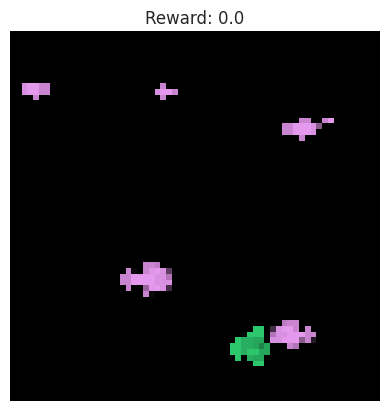

In [45]:
obs = env.reset()
reward = 0
try:
    while True:
        ts = env.step(env.action_space.sample())
        plt_render(env, ts.reward)
        if ts.step_type == time_step.StepType.LAST:
            break

except KeyboardInterrupt:
    clear_output(wait=True)
    plt_render(env, reward)

In [2]:
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.policies import TFPolicy
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.policies.random_py_policy import RandomPyPolicy
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [47]:
tf_env = TFPyEnvironment(BatchedPyEnvironment([create_stacked_coinrun_env() for _ in range(4)]))
tf_env.reset()

random_policy = RandomTFPolicy(
    tf_env.time_step_spec(),
    tf_env.action_spec()
)

In [48]:
tf_env.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': TensorSpec(shape=(64, 64, 4), dtype=tf.float64, name='stacked_frames'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [49]:
policy_step = random_policy.action(tf_env.current_time_step())
ts = tf_env.step(policy_step.action)

In [50]:
from mlrl.utils import render_utils

In [3]:
def get_grid_dim(n):
    sqrt_n = np.sqrt(n)
    p = 1
    for i in range(1, int(np.ceil(np.sqrt(n)))):
        if n % i == 0:
            p = n / i
    q = n / p
    return int(p), int(q)


p, q = get_grid_dim(4)


def render_fn(batched_env, *_):
    
    def render_env(env):
        img = env.render()
        img = cv2.resize(img, (4*img.shape[0], 4*img.shape[1]),
                         interpolation=cv2.INTER_NEAREST)
        return img
    
    frames = [
        render_env(e)
        for i, e in enumerate(batched_env.envs)
    ]
    
    return np.concatenate([
        np.concatenate(frames[i*q:(i+1)*q]) for i in range(p)
    ], axis=1)

In [52]:
render_utils.embed_mp4(render_utils.save_policy_eval_video(
    random_policy, tf_env, render_fn, 'video', max_steps=15*30, fps=5), width=4*256, height=256)

In [4]:
class QNet(tf.keras.Model):

    def __init__(self, n_actions: int, enc_dim=64, n_channels=3):
        super(QNet, self).__init__()

        self.n_actions = n_actions
        self.enc_dim = enc_dim
        self.n_channels = n_channels

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (8, 8), 
                                   activation='relu', 
                                   input_shape=(64, 64, n_channels), strides=4),
            tf.keras.layers.Conv2D(64, (4, 4), activation='relu', strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(enc_dim, activation='relu'),
        ], name='encoder')

        self.q = tf.keras.layers.Dense(n_actions, activation=None, name='q')
    
    def call(self, x, training=False):
        z = self.encoder(x, training=training)
        return self.q(z, training=training)

    def get_config(self):
        return {
            'n_actions': self.n_actions,
            'enc_dim': self.enc_dim,
            'n_channels': self.n_channels
        }

In [54]:
n_actions = 1 + int(tf_env.action_spec().maximum)
n_channels = tf_env.observation_spec().shape[-1]
q_net = QNet(n_actions=n_actions, n_channels=n_channels, enc_dim=512)
q_net_target = QNet(n_actions=n_actions, n_channels=n_channels, enc_dim=512)

In [55]:
ts = tf_env.current_time_step()
q_net(ts.observation), q_net_target(ts.observation)

(<tf.Tensor: shape=(4, 15), dtype=float32, numpy=
 array([[ 0.00380501, -0.00509706,  0.00611416,  0.00731102, -0.00867142,
         -0.01302513,  0.00885907,  0.00024419,  0.01485295, -0.00246146,
         -0.01530804,  0.01584195, -0.02962426, -0.00241169,  0.00850573],
        [ 0.0018752 , -0.00248517, -0.0019919 , -0.00016947, -0.00382741,
         -0.00034675,  0.0002352 , -0.00167084,  0.00486593, -0.00138648,
         -0.00282137,  0.00320719, -0.00946077,  0.00520492, -0.00087974],
        [-0.00339132, -0.00684172,  0.00757659, -0.0239379 , -0.02864715,
         -0.0105958 ,  0.00237662,  0.00630284,  0.02301122,  0.01983851,
         -0.01191829,  0.01432768, -0.03162514,  0.00263053,  0.00983094],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
       dtype=float32)>,
 <tf.Tensor: shape=(4, 15), dtype

In [56]:
q_net.summary()

Model: "q_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 512)               250560    
                                                                 
 q (Dense)                   multiple                  7695      
                                                                 
Total params: 258,255
Trainable params: 258,255
Non-trainable params: 0
_________________________________________________________________


In [60]:
from tf_agents.agents.dqn.dqn_agent import DdqnAgent
from tf_agents.agents import CategoricalDqnAgent
from tf_agents.networks.sequential import Sequential

In [86]:
from tf_agents.networks.categorical_q_network import CategoricalQNetwork


c51_q_net = CategoricalQNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    conv_layer_params=[(64, 8, 4), (64, 4, 2), (64, 3, 2)],
    fc_layer_params=[512]
)

In [87]:
q_vals, _ = c51_q_net(tf_env.current_time_step().observation)
q_vals.shape

TensorShape([4, 15, 51])

In [88]:
c51_q_net.summary()
c51_q_net._q_network.summary()
c51_q_net._q_network._encoder.summary()

Model: "CategoricalQNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CategoricalQNetwork (QNetwor multiple                  643005    
Total params: 643,005
Trainable params: 643,005
Non-trainable params: 0
_________________________________________________________________
Model: "CategoricalQNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  250560    
_________________________________________________________________
dense_17 (Dense)             multiple                  392445    
Total params: 643,005
Trainable params: 643,005
Non-trainable params: 0
_________________________________________________________________
Model: "EncodingNetwork"
_________________________________________________________________
Layer (type)                 Output Shape      

In [209]:
from procgen import ProcgenGym3Env
from gym3 import ExtractDictObWrapper
# from gym3 import ToGymEnv
test_env = ExtractDictObWrapper(ProcgenGym3Env(num=64, num_threads=16, env_name="coinrun"), key='rgb')

In [126]:
%%timeit
test_env.act(np.array([0]*64))

627 µs ± 45.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [107]:
%%timeit
test_env.act(np.array([0]*64))

1.52 ms ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [110]:
batched_test_env = BatchedPyEnvironment([GymWrapper(gym.make("procgen-coinrun-v0")) for _ in range(64)])

In [111]:
%%timeit
batched_test_env.step(np.array([0]*64))

38.6 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [403]:

from tf_agents.environments.gym_wrapper import spec_from_gym_space

In [404]:

from gym3.interop import _space2vt, _vt2space, _assert_num_envs_1

In [615]:
# import collections
# from typing import Any, Dict, Optional, Text

# import gym
# import gym.spaces
# import numpy as np
# import tensorflow as tf

# from tf_agents import specs
# from tf_agents.environments import py_environment
# from tf_agents.trajectories import time_step as ts
# from tf_agents.typing import types

# from tensorflow.python.util import nest  # pylint:disable=g-direct-tensorflow-import  # TF internal
# from typing import Any, Dict, List, Sequence, Tuple

# import numpy as np

# from gym3 import types_np
# from gym3.concat import ConcatEnv
# from gym3.env import Env
# from gym3.internal import misc
# from gym3.subproc import SubprocEnv
# from gym3.types import (
#     DictType,
#     Discrete,
#     Real,
#     TensorType,
#     ValType,
#     multimap,
#     INTEGER_DTYPE_NAMES,
#     FLOAT_DTYPE_NAMES,
# )


# def _space2vt(space: "gym.spaces.Space"):
#     from gym import spaces

#     if isinstance(space, spaces.Box):
#         if space.dtype.name in INTEGER_DTYPE_NAMES:
#             high = space.high.flat[0]
#             assert (space.low == 0).all() and (
#                 space.high == high
#             ).all(), "only identical high/low bounds across all dimensions are supported, and low must be 0 for integer types, please wrap your environment to adjust your Box space bounds, split into a Dict space, or use float32 as the dtype"
#             return TensorType(
#                 shape=space.shape,
#                 eltype=Discrete(n=high + 1, dtype_name=space.dtype.name),
#             )
#         else:
#             assert (
#                 space.dtype.name in FLOAT_DTYPE_NAMES
#             ), f"only {FLOAT_DTYPE_NAMES} is supported for real values, please wrap your environment so that a valid dtype is used"
#             return TensorType(shape=space.shape, eltype=Real(dtype_name=space.dtype.name))
#     elif isinstance(space, spaces.Discrete):
#         return TensorType(
#             shape=(), eltype=Discrete(space.n, dtype_name=space.dtype.name)
#         )
#     elif isinstance(space, spaces.MultiDiscrete):
#         assert misc.allsame(
#             space.nvec
#         ), f"only multidiscrete with identical values of n is allowed, please wrap your environment so that it has a Dict space with individual Discrete spaces for each dimension instead"
#         return TensorType(
#             shape=(len(space.nvec),),
#             eltype=Discrete(space.nvec[0], dtype_name=space.dtype.name),
#         )
#     elif isinstance(space, spaces.MultiBinary):
#         return TensorType(
#             shape=(space.n,), eltype=Discrete(2, dtype_name=space.dtype.name)
#         )
#     elif isinstance(space, spaces.Dict):
#         return DictType(
#             **{name: _space2vt(subspace) for (name, subspace) in space.spaces.items()}
#         )
#     elif isinstance(space, spaces.Tuple):
#         assert (
#             False
#         ), "tuple space not supported, please wrap your environment so that it has a Dict space instead of a Tuple space"
#     else:
#         raise NotImplementedError


# def _vt2space(vt: ValType):
#     from gym import spaces

#     def tt2space(tt: TensorType):
#         if isinstance(tt.eltype, Discrete):
#             if tt.ndim == 0:
#                 return spaces.Discrete(tt.eltype.n)
#             else:
#                 return spaces.Box(
#                     low=0,
#                     high=tt.eltype.n - 1,
#                     shape=tt.shape,
#                     dtype=types_np.dtype(tt),
#                 )
#         elif isinstance(tt.eltype, Real):
#             return spaces.Box(
#                 shape=tt.shape,
#                 dtype=types_np.dtype(tt),
#                 low=float("-inf"),
#                 high=float("inf"),
#             )
#         else:
#             raise NotImplementedError

#     space = multimap(tt2space, vt)

#     def dict2dict_space(d):
#         if isinstance(d, dict):
#             return spaces.Dict({k: dict2dict_space(v) for k, v in d.items()})
#         else:
#             return d

#     return dict2dict_space(space)


# def _assert_num_envs_1(ac):
#     """ Check that the action is consistent with num_envs = 1 """
#     if isinstance(ac, dict):
#         for a in ac.values():
#             _assert_num_envs_1(a)
#     else:
#         assert len(ac) == 1



# def spec_from_gym_space(space: gym.Space,
#                         dtype_map: Optional[Dict[gym.Space, np.dtype]] = None,
#                         simplify_box_bounds: bool = True,
#                         name: Optional[Text] = None) -> specs.BoundedArraySpec:
#   """Converts gym spaces into array specs.
#   Gym does not properly define dtypes for spaces. By default all spaces set
#   their type to float64 even though observations do not always return this type.
#   See:
#   https://github.com/openai/gym/issues/527
#   To handle this we allow a dtype_map for setting default types for mapping
#   spaces to specs.
#   TODO(oars): Support using different dtypes for different parts of the
#   observations. Not sure that we have a need for this yet.
#   Args:
#     space: gym.Space to turn into a spec.
#     dtype_map: A dict from spaces to dtypes to use as the default dtype.
#     simplify_box_bounds: Whether to replace bounds of Box space that are arrays
#       with identical values with one number and rely on broadcasting.
#     name: Name of the spec.
#   Returns:
#     A BoundedArraySpec nest mirroring the given space structure.
#   Raises:
#     ValueError: If there is an unknown space type.
#   """
#   if dtype_map is None:
#     dtype_map = {}

#   # We try to simplify redundant arrays to make logging and debugging less
#   # verbose and easier to read since the printed spec bounds may be large.
#   def try_simplify_array_to_value(np_array):
#     """If given numpy array has all the same values, returns that value."""
#     first_value = np_array.item(0)
#     if np.all(np_array == first_value):
#       return np.array(first_value, dtype=np_array.dtype)
#     else:
#       return np_array

#   def nested_spec(spec, child_name):
#     """Returns the nested spec with a unique name."""
#     nested_name = name + '/' + child_name if name else child_name
#     return spec_from_gym_space(spec, dtype_map, simplify_box_bounds,
#                                nested_name)

#   if isinstance(space, gym.spaces.Discrete):
#     # Discrete spaces span the set {0, 1, ... , n-1} while Bounded Array specs
#     # are inclusive on their bounds.
#     maximum = space.n - 1
#     # TODO(oars): change to use dtype in space once Gym is updated.
#     dtype = dtype_map.get(gym.spaces.Discrete, np.int64)
#     return specs.BoundedArraySpec(
#         shape=(), dtype=dtype, minimum=0, maximum=maximum, name=name)
#   elif isinstance(space, gym.spaces.MultiDiscrete):
#     dtype = dtype_map.get(gym.spaces.MultiDiscrete, np.int32)
#     maximum = try_simplify_array_to_value(
#         np.asarray(space.nvec - 1, dtype=dtype))
#     return specs.BoundedArraySpec(
#         shape=space.shape, dtype=dtype, minimum=0, maximum=maximum, name=name)
#   elif isinstance(space, gym.spaces.MultiBinary):
#     dtype = dtype_map.get(gym.spaces.MultiBinary, np.int32)
#     # Can remove this once we update gym.
#     if isinstance(space.n, int):
#       shape = (space.n,)
#     else:
#       shape = tuple(space.n)
#     return specs.BoundedArraySpec(
#         shape=shape, dtype=dtype, minimum=0, maximum=1, name=name)
#   elif isinstance(space, gym.spaces.Box):
#     if hasattr(space, 'dtype') and gym.spaces.Box not in dtype_map:
#       dtype = space.dtype
#     else:
#       dtype = dtype_map.get(gym.spaces.Box, np.float32)
#     if dtype == tf.string:
#       return specs.ArraySpec(shape=space.shape, dtype=dtype, name=name)
#     minimum = np.asarray(space.low, dtype=dtype)
#     maximum = np.asarray(space.high, dtype=dtype)
#     if simplify_box_bounds:
#       simple_minimum = try_simplify_array_to_value(minimum)
#       simple_maximum = try_simplify_array_to_value(maximum)
#       # Can only simplify if both bounds are simplified. Otherwise
#       # broadcasting doesn't work from non-simplified to simplified.
#       if simple_minimum.shape == simple_maximum.shape:
#         minimum = simple_minimum
#         maximum = simple_maximum
#     return specs.BoundedArraySpec(
#         shape=space.shape,
#         dtype=dtype,
#         minimum=minimum,
#         maximum=maximum,
#         name=name)
#   elif isinstance(space, gym.spaces.Tuple):
#     return tuple(
#         [nested_spec(s, 'tuple_%d' % i) for i, s in enumerate(space.spaces)])
#   elif isinstance(space, gym.spaces.Dict):
#     return collections.OrderedDict([
#         (key, nested_spec(s, key)) for key, s in space.spaces.items()
#     ])
#   else:
#     raise ValueError(
#         'The gym space {} is currently not supported.'.format(space))


# class ProcgenGym3Wrapper(py_environment.PyEnvironment):
#   """Base wrapper implementing PyEnvironmentBaseWrapper interface for Gym envs.
#   Action and observation specs are automatically generated from the action and
#   observation spaces. See base class for py_environment.Base details.
#   """

#   def __init__(self,
#                gym_env: procgen.ProcgenGym3Env,
#                discount: types.Float = 1.0,
#                action_repeats: types.Int = 1,
#                spec_dtype_map: Optional[Dict[gym.Space, np.dtype]] = None,
#                match_obs_space_dtype: bool = True,
#                auto_reset: bool = False,
#                simplify_box_bounds: bool = True,
#                render_kwargs: Optional[Dict[str, Any]] = None,
#                ):
#     super(ProcgenGym3Wrapper, self).__init__(auto_reset)

#     self._n_envs = gym_env.num
#     self._gym_env = gym_env
#     self._discount = discount
#     self._action_repeats = action_repeats

#     self._gym_observation_space = _vt2space(gym_env.ob_space)
#     self._gym_action_space = _vt2space(gym_env.ac_space)
#     self.metadata = {"render.modes": ["human", "rgb_array"]}
#     self.reward_range = (-float("inf"), float("inf"))
#     self.spec = None

#     self._action_is_discrete = isinstance(self._gym_action_space,
#                                           gym.spaces.Discrete)
#     self._match_obs_space_dtype = match_obs_space_dtype
#     self._observation_spec = spec_from_gym_space(
#         self._gym_observation_space, spec_dtype_map, simplify_box_bounds,
#         'observation')
#     self._action_spec = spec_from_gym_space(self._gym_action_space,
#                                             spec_dtype_map, simplify_box_bounds,
#                                             'action')
#     self._flat_obs_spec = tf.nest.flatten(self._observation_spec)
#     self._render_kwargs = render_kwargs or {}
#     self._info = None
#     self._done = [False] * self._n_envs
#     self._is_first = [True] * self._n_envs

#   @property
#   def batched(self) -> bool:
#     return self._n_envs > 1

#   @property
#   def batch_size(self) -> int:
#     return self._n_envs

#   @property
#   def gym(self) -> gym.Env:
#     return self._gym_env

#   def __getattr__(self, name: Text) -> Any:
#     """Forward all other calls to the base environment."""
#     gym_env = super(ProcgenGym3Wrapper, self).__getattribute__('_gym_env')
#     return getattr(gym_env, name)

#   def get_info(self) -> Any:
#     """Returns the gym environment info returned on the last step."""
#     return self._info

#   def _reset(self):
#     self._is_first = [True] * self._n_envs
#     self._current_time_step = self._create_time_step()
#     return self._current_time_step

#   @property
#   def done(self) -> bool:
#     return any(self._done)

#   def _step(self, action):

#     if type(action) in [int, np.int32, np.int64]:
#         action = np.array([action])
      
#     elif isinstance(action, tf.Tensor):
#         action = action.numpy()

#     self._gym_env.act(action)

#     self._current_time_step = self._create_time_step()
#     return self._current_time_step

#   def _create_time_step(self):
#     reward, observation, self._done = self._gym_env.observe()

#     step_type = [ts.StepType.MID] * self._n_envs
#     for i in range(self._n_envs):
#       if self._is_first[i]:
#         step_type[i] = ts.StepType.FIRST
#         self._is_first[i] = False
#       elif self._done[i]:
#         step_type[i] = ts.StepType.LAST
#         self._is_first[i] = True

#     # step_type = np.array([
#     #     ts.StepType.LAST if done[i] else ts.StepType.MID
#     #     for i in range(self._n_envs)
#     # ])
#     return ts.TimeStep(step_type=np.array(step_type),
#                        reward=reward,
#                        discount=self._discount,
#                        observation=observation)

#   def _to_obs_space_dtype(self, observation):
#     """
#     Make sure observation matches the specified space.
#     Observation spaces in gym didn't have a dtype for a long time. Now that they
#     do there is a large number of environments that do not follow the dtype in
#     the space definition. Since we use the space definition to create the
#     tensorflow graph we need to make sure observations match the expected
#     dtypes.
#     Args:
#       observation: Observation to match the dtype on.
#     Returns:
#       The observation with a dtype matching the observation spec.
#     """
#     # Make sure we handle cases where observations are provided as a list.
#     flat_obs = nest.flatten_up_to(self._observation_spec, observation)

#     matched_observations = []
#     for spec, obs in zip(self._flat_obs_spec, flat_obs):
#       matched_observations.append(np.asarray(obs, dtype=spec.dtype))
#     return tf.nest.pack_sequence_as(self._observation_spec,
#                                     matched_observations)

#   def observation_spec(self) -> types.NestedArraySpec:
#     return self._observation_spec

#   def action_spec(self) -> types.NestedArraySpec:
#     return self._action_spec

#   def close(self) -> None:
#     return self._gym_env.close()

#   def seed(self, seed: types.Seed) -> types.Seed:
#     seed_value = self._gym_env.seed(seed)
#     if seed_value is None:
#       return 0
#     return seed_value

#   def render(self, mode: Text = 'rgb_array') -> Any:
#     return self._gym_env.render(mode, **self._render_kwargs)

#   # pytype: disable=attribute-error
#   def set_state(self, state: Any) -> None:
#     return self._gym_env.set_state(state)

#   def get_state(self) -> Any:
#     return self._gym.get_state()
#   # pytype: enable=attribute-error

In [92]:
from typing import Any, Dict, Optional, Text

import numpy as np

import gym
import gym.spaces
from gym3.interop import _vt2space
import procgen

import tensorflow as tf
from tensorflow.python.util import nest

from tf_agents.environments import py_environment
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types
from tf_agents.environments.gym_wrapper import spec_from_gym_space


class ProcgenGym3Wrapper(py_environment.PyEnvironment):
    """
    Base wrapper implementing PyEnvironmentBaseWrapper interface for Gym envs.
    Action and observation specs are automatically generated from the action and
    observation spaces. See base class for py_environment.Base details.

    Based on the GymWrapper class and ToGymEnv classes from tf_agents and gym3.
    """

    def __init__(self,
        gym_env: procgen.ProcgenGym3Env,
        discount: types.Float = 1.0,
        action_repeats: types.Int = 1,
        match_obs_space_dtype: bool = True,
        simplify_box_bounds: bool = True,
        render_kwargs: Optional[Dict[str, Any]] = None,
        spec_dtype_map: Optional[Dict[gym.Space, np.dtype]] = None,
    ):
        """
        Initializes the wrapper.

        Args:
            gym_env: The procgen gym3 environment to wrap. Assumed to contain multiple envs.
            discount: Discount to use for the environment.
            action_repeats: Number of times to repeat the action with each step.
            spec_dtype_map: A dictionary mapping gym spaces to dtypes.
        """
        super(ProcgenGym3Wrapper, self).__init__(handle_auto_reset=False)

        self._n_envs = gym_env.num
        self._gym_env = gym_env
        self._discount = np.array([discount] * self._n_envs)
        self._action_repeats = action_repeats

        self._gym_observation_space = _vt2space(gym_env.ob_space)
        self._gym_action_space = _vt2space(gym_env.ac_space)
        self.metadata = {"render.modes": ["human", "rgb_array"]}
        self.reward_range = (-float("inf"), float("inf"))
        self.spec = None

        self._action_is_discrete = isinstance(self._gym_action_space,
                                              gym.spaces.Discrete)
        self._match_obs_space_dtype = match_obs_space_dtype
        self._observation_spec = spec_from_gym_space(self._gym_observation_space,
                                                     spec_dtype_map,
                                                     simplify_box_bounds,
                                                     'observation')
        self._action_spec = spec_from_gym_space(self._gym_action_space,
                                                spec_dtype_map,
                                                simplify_box_bounds,
                                                'action')
        self._flat_obs_spec = tf.nest.flatten(self._observation_spec)
        self._render_kwargs = render_kwargs or {}
        self._info = None
        self._done = [False] * self._n_envs
        self._is_first = [True] * self._n_envs

    @property
    def gym(self) -> gym.Env:
        return self._gym_env

    @property
    def batched(self) -> bool:
        return self._n_envs > 1

    @property
    def batch_size(self) -> int:
        return self._n_envs

    def __getattr__(self, name: Text) -> Any:
        """Forward all other calls to the base environment."""
        gym_env = super(ProcgenGym3Wrapper, self).__getattribute__('_gym_env')
        return getattr(gym_env, name)

    def get_info(self) -> Any:
        """Returns the gym environment info returned on the last step."""
        return self._info

    def _reset(self):
        self._current_time_step = self._create_time_step()
        return self._current_time_step

    @property
    def done(self) -> bool:
        return self._done

    def _step(self, action):

        if type(action) in [int, np.int32, np.int64]:
            action = np.array([action])

        elif isinstance(action, tf.Tensor):
            action = action.numpy()

        self._gym_env.act(action)

        self._current_time_step = self._create_time_step()
        return self._current_time_step

    def _create_time_step(self):
        reward, observation, self._done = self._gym_env.observe()

        step_type = [ts.StepType.MID] * self._n_envs

        for i in range(self._n_envs):
            if self._is_first[i]:
                step_type[i] = ts.StepType.FIRST
                self._is_first[i] = False
            elif self._done[i]:
                step_type[i] = ts.StepType.LAST
                self._is_first[i] = True

        return ts.TimeStep(step_type=np.array(step_type),
                           reward=reward,
                           discount=self._discount,
                           observation=observation)

    def _to_obs_space_dtype(self, observation):
        """
        Make sure observation matches the specified space.
        Observation spaces in gym didn't have a dtype for a long time. Now that they
        do there is a large number of environments that do not follow the dtype in
        the space definition. Since we use the space definition to create the
        tensorflow graph we need to make sure observations match the expected
        dtypes.
        Args:
        observation: Observation to match the dtype on.
        Returns:
        The observation with a dtype matching the observation spec.
        """
        # Make sure we handle cases where observations are provided as a list.
        flat_obs = nest.flatten_up_to(self._observation_spec, observation)

        matched_observations = []
        for spec, obs in zip(self._flat_obs_spec, flat_obs):
            matched_observations.append(np.asarray(obs, dtype=spec.dtype))
        return tf.nest.pack_sequence_as(self._observation_spec,
                            matched_observations)

    def observation_spec(self) -> types.NestedArraySpec:
        return self._observation_spec

    def action_spec(self) -> types.NestedArraySpec:
        return self._action_spec

    def close(self) -> None:
        return self._gym_env.close()

    def seed(self, seed: types.Seed) -> types.Seed:
        seed_value = self._gym_env.seed(seed)
        if seed_value is None:
            return 0
        return seed_value

    def render(self, mode: Text = 'rgb_array') -> Any:
        return self._gym_env.render(mode, **self._render_kwargs)

    def set_state(self, state: Any) -> None:
        return self._gym_env.set_state(state)

    def get_state(self) -> Any:
        return self._gym_env.get_state()


In [93]:
from procgen import ProcgenGym3Env
from gym3 import ExtractDictObWrapper
# from gym3 import ToGymEnv
n_test_envs = 12
test_env = ExtractDictObWrapper(ProcgenGym3Env(
    num=n_test_envs, num_threads=16,
                        env_name="jumper",
                        use_backgrounds=False,
                        restrict_themes=True,
                        distribution_mode='easy'
), key='rgb')
wrapped_procgen = ProcgenGym3Wrapper(test_env, action_repeats=4)
wrapped_procgen.reset();

In [94]:
def get_grid_dim(n):
    sqrt_n = int(np.sqrt(n))
    p = 1
    for i in range(1, sqrt_n + 1):
        if n % i == 0:
            p = n / i
    q = n / p
    return int(p), int(q)


p, q = get_grid_dim(n_test_envs)


import cv2

def render_fn(vectorised_env, *_):
    
    current_ts = vectorised_env.current_time_step()
    observation = current_ts.observation

    def render_env(i):
        img = observation[i]
        img = cv2.resize(img, (4*img.shape[0], 4*img.shape[1]),
                         interpolation=cv2.INTER_NEAREST)
        return img
    
    frames = [
        render_env(i)
        for i in range(wrapped_procgen._n_envs)
    ]
    
    return np.concatenate([
        np.concatenate(frames[i*q:(i+1)*q]) for i in range(p)
    ], axis=1)

In [96]:
current_ts = wrapped_procgen.current_time_step()
obs = current_ts.observation

D_key = wrapped_procgen._gym_env.env.keys_to_act(['RIGHT'])[0].item()

try:
    running = True
    while running:
    
        plt.figure(figsize=(10, 10))
        plt.imshow(render_fn(wrapped_procgen))
        plt.axis('off')
        plt.show()
        clear_output(wait=True)

        curr_ts = wrapped_procgen.step(np.array([
            wrapped_procgen._gym_action_space.sample() if np.random.rand() < 0.1 else D_key
            for _ in range(wrapped_procgen._n_envs)
        ]))

        # running = not curr_ts.is_last().any()

except KeyboardInterrupt:
    pass

<Figure size 720x720 with 0 Axes>

In [8]:
%%timeit
test_env.act(np.array([0] * n_test_envs))
test_env.observe()

829 µs ± 79.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
procgen_gym3 = ExtractDictObWrapper(ProcgenGym3Env(num=n_test_envs, num_threads=min(n_test_envs, 32), env_name="coinrun",
                        use_backgrounds=False,
                        restrict_themes=True,
                        distribution_mode='easy'), key='rgb')
wrapped_procgen_gym3 = ProcgenGym3Wrapper(procgen_gym3, action_repeats=4)

In [10]:
%%timeit
wrapped_procgen_gym3.step(np.array([0] * n_test_envs))

607 µs ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [691]:
py_batched_env = BatchedPyEnvironment([
    ActionRepeat(GymWrapper(gym.make("procgen-coinrun-v0")), 4) for _ in range(n_test_envs)
])

In [692]:
%%timeit
py_batched_env.step(np.array([0] * n_test_envs))

149 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [693]:
wrapped_procgen.action_spec(), wrapped_procgen.observation_spec()

(BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=14),
 BoundedArraySpec(shape=(64, 64, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [694]:
batched_test_env.action_spec(), batched_test_env.observation_spec()

(BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=14),
 BoundedArraySpec(shape=(64, 64, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [64]:
from mlrl.utils.env_wrappers import ImagePreprocessWrapper, FrameStack
from tf_agents.environments import ActionRepeat
frame_skip = 4
frame_stack = 4

procgen_gym3 = ExtractDictObWrapper(ProcgenGym3Env(
                        num=64,
                        num_threads=32,
                        env_name="starpilot",
                        use_backgrounds=False,
                        restrict_themes=True,
                        distribution_mode='easy'), key='rgb')

wrapped_procgen_gym3 = ProcgenGym3Wrapper(procgen_gym3, action_repeats=frame_skip)
env = ImagePreprocessWrapper(wrapped_procgen_gym3)
env = FrameStack(env, frame_stack)    
env.reset();

In [65]:
from tf_agents.networks.q_network import QNetwork

q_net = QNetwork(
    env.observation_spec(),
    env.action_spec(),
    conv_layer_params=[(64, 8, 4), (64, 4, 2), (64, 3, 2)],
    fc_layer_params=[512]
)

q_model = tf.keras.Sequential([q_net])
q_model(env.current_time_step().observation);

outputs, _ = q_net(env.current_time_step().observation)
q_net.summary()

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  250560    
_________________________________________________________________
dense_21 (Dense)             multiple                  7695      
Total params: 258,255
Trainable params: 258,255
Non-trainable params: 0
_________________________________________________________________


In [66]:
from tf_agents.specs import tensor_spec
from tf_agents.agents.dqn.dqn_agent import DdqnAgent


optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-4)
train_step_counter = tf.Variable(0)

agent = DdqnAgent(
    tensor_spec.from_spec(env.time_step_spec()),
    tensor_spec.from_spec(env.action_spec()),
    q_network=q_net,
    # target_q_network=Sequential([q_net_target]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    target_update_period=20000,
    train_step_counter=train_step_counter
)

agent.initialize()

In [67]:
from tf_agents.networks.categorical_q_network import CategoricalQNetwork
from tf_agents.agents import CategoricalDqnAgent


c51_q_net = CategoricalQNetwork(
    tensor_spec.from_spec(env.observation_spec()),
    tensor_spec.from_spec(env.action_spec()),
    conv_layer_params=[(64, 8, 4), (64, 4, 2), (64, 3, 2)],
    fc_layer_params=[512]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-4)
train_step_counter = tf.Variable(0)

agent = CategoricalDqnAgent(
    tensor_spec.from_spec(env.time_step_spec()),
    tensor_spec.from_spec(env.action_spec()),
    categorical_q_network=c51_q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    target_update_period=20000,
    min_q_value=0, max_q_value=25,
    gamma=0.999,
    train_step_counter=train_step_counter
)

agent.initialize()

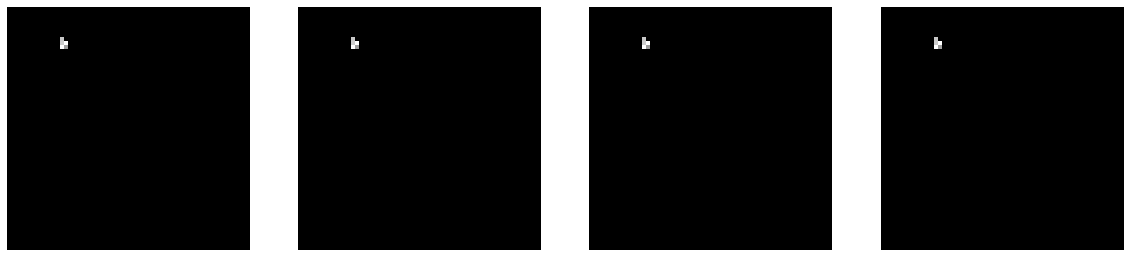

In [69]:
curr_ts = env.current_time_step()
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    img = curr_ts.observation[0, ..., i]
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.show()

In [70]:
from mlrl.runners.eval_runner import EvalRunner
eval_runner = EvalRunner(
                env.batch_size * 1000,
                env,
                agent.collect_policy)
eval_runner.run()

64034/64000 [==============================] - 18s 283us/step - AverageReturn: 4.5284
Evaluation stats:
EvalNumberOfEpisodes: 799.000, EvalEnvironmentSteps: 64034.000, EvalAverageReturn: 9.090, EvalAverageEpisodeLength: 76.837, EvalTime: 18.149


{'EvalNumberOfEpisodes': 799,
 'EvalEnvironmentSteps': 64034,
 'EvalAverageReturn': 9.090113,
 'EvalAverageEpisodeLength': 76.837296,
 'EvalTime': 18.149495363235474}

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_step_counter = tf.Variable(0)

agent = DdqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=Sequential([q_net]),
    target_q_network=Sequential([q_net_target]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    target_update_period=20000,
    train_step_counter=train_step_counter
)

agent.initialize()

In [131]:
from mlrl.runners.eval_runner import EvalRunner
from tf_agents import environments

In [637]:
random_eval_runner = EvalRunner(
                16000,
                environments.BatchedPyEnvironment([
                    create_stacked_coinrun_env()
                    for _ in range(16)
                ]),
                random_policy)

random_eval_runner.run()

ValueError: Received a mix of batched and unbatched Tensors, or Tensors are not compatible with Specs.  num_outer_dims: 1.
Saw tensor_shapes:
   TimeStep(
{'discount': TensorShape([]),
 'observation': TensorShape([64, 64, 64, 4]),
 'reward': TensorShape([64]),
 'step_type': TensorShape([64])})
And spec_shapes:
   TimeStep(
{'discount': TensorShape([]),
 'observation': TensorShape([64, 64, 4]),
 'reward': TensorShape([]),
 'step_type': TensorShape([])})

In [365]:
from mlrl.runners.eval_runner import EvalRunner
eval_runner = EvalRunner(
                16000,
                environments.BatchedPyEnvironment([
                    create_stacked_coinrun_env()
                    for _ in range(16)
                ]),
                agent.policy)
eval_runner.run()

16002/16000 [==============================] - 24s 1ms/step - AverageReturn: 0.5312
Evaluation stats:
EvalNumberOfEpisodes: 142.000, EvalEnvironmentSteps: 16002.000, EvalAverageReturn: 0.697, EvalAverageEpisodeLength: 103.746, EvalTime: 23.950


{'EvalNumberOfEpisodes': 142,
 'EvalEnvironmentSteps': 16002,
 'EvalAverageReturn': 0.6971831,
 'EvalAverageEpisodeLength': 103.746475,
 'EvalTime': 23.95006036758423}

In [20]:
%%timeit
curr_ts = env.current_time_step()
policy_step = agent.policy.action(curr_ts)
env.step(policy_step.action.numpy());

26.1 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
py_batched_env = BatchedPyEnvironment([
    FrameStack(ImagePreprocessWrapper(ActionRepeat(GymWrapper(gym.make("procgen-coinrun-v0")), 4)), 4) for _ in range(64)
])
py_batched_env.reset();

In [22]:
%%timeit
curr_ts = py_batched_env.current_time_step()
policy_step = agent.policy.action(curr_ts)
py_batched_env.step(policy_step.action.numpy());

195 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [368]:
eval_runner = EvalRunner(
                16000,
                environments.BatchedPyEnvironment([
                    create_stacked_coinrun_env()
                    for _ in range(16)
                ]),
                agent.policy)
eval_runner.run()

/usr/local/lib/python3.10/dist-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/usr/local/lib/python3.10/dist-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/usr/local/lib/python3.10/dist-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/usr/local/lib/python3.10/dist-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/usr/local/lib/python3.10/dist-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did

ValueError: <tf_agents.networks.q_network.QNetwork object at 0x7f38ec321ff0>: Inconsistent dtypes or shapes between `inputs` and `input_tensor_spec`.
dtypes:
<dtype: 'uint8'>
vs.
<dtype: 'float64'>.
shapes:
(64, 64, 64, 3)
vs.
(64, 64, 4).

In [20]:
from typing import Optional, List
from tf_agents.drivers import py_driver


def create_policy_eval_video_frames(
        policy, env,
        render_fn=None,
        max_envs_to_show: Optional[int] = None,
        stack='vertical',
        steps: int = 60) -> List[np.ndarray]:
    """
    Creates a video of the policy acting in the given environment.
    If the environment is a batched environment, then multiple episodes
    will be shown stacked vertically.

    Args:
        policy (TFPolicy): The policy to evaluate.
        meta_env (TFEnvironment): The environment to evaluate the policy in.
        max_envs_to_show (Optional[int]): The maximum number of environments to show.
        steps (int): The maximum number of steps to run the policy for.

    Returns:
        List[np.ndarray]: A list of numpy arrays containing the frames of the video.
    """
    render_fn = render_fn or (lambda e: e.render())

    frames = []

    def observe(_):
        frames.append(render_fn(env))

    driver = py_driver.PyDriver(
        env, policy,
        max_steps=steps,
        observers=[observe]
    )
    
    driver.run(env.current_time_step())

    return frames


n_video_envs = 12

video_env = environments.BatchedPyEnvironment([
    GymWrapper(gym.make('procgen-coinrun-v0'))
    for _ in range(n_video_envs)
])
video_env.reset()


def get_grid_dim(n):
    sqrt_n = np.sqrt(n)
    p = 1
    for i in range(1, int(np.ceil(np.sqrt(n)))):
        if n % i == 0:
            p = n / i
    q = n / p
    return int(p), int(q)


p, q = get_grid_dim(n_video_envs)


def render_fn(batched_env, *_):
    
    def render_env(env):
        cenv = env.env
        img = cenv.observe()[1][0]
        img = cv2.resize(img, (4*img.shape[0], 4*img.shape[1]),
                         interpolation=cv2.INTER_NEAREST)
        return img
    
    frames = [
        render_env(e)
        for i, e in enumerate(batched_env.envs)
    ]
    
    return np.concatenate([
        np.concatenate(frames[i*q:(i+1)*q]) for i in range(p)
    ], axis=1)

In [23]:
from mlrl.runners.dqn_runner import DQNRun

fps = 15

collect_env = environments.BatchedPyEnvironment([
    GymWrapper(gym.make('procgen-coinrun-v0'))
    for _ in range(16)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_step_counter = tf.Variable(0)

agent = DdqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=Sequential([q_net]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    target_update_period=20000,
    train_step_counter=train_step_counter
)
agent.initialize()

eval_runner = EvalRunner(
        16000,
        environments.BatchedPyEnvironment([
            GymWrapper(gym.make('procgen-coinrun-v0'))
            for _ in range(16)
        ]),
        agent.policy)


from mlrl.utils.render_utils import save_video

def create_video(policy, video_file):
    frames = create_policy_eval_video_frames(
        policy, video_env, 
        render_fn=render_fn, steps=15*60*n_video_envs
    )
    return save_video(frames, video_file, fps=15)


dqn_run = DQNRun(
    agent, collect_env, q_net,
    eval_runner=eval_runner,
    create_video_fn=create_video,
    video_freq=5,
    train_steps_per_epoch=10000,
    num_epochs=500
)

In [24]:
dqn_run.create_evaluation_video('video')

Failed to create evaluation video: You must call wandb.init() before wandb.log()


In [27]:
from mlrl.utils.render_utils import embed_mp4

embed_mp4(f'{dqn_run.videos_dir}/video.mp4')

In [ ]:
from ..meta.search_tree import ObjectState
from ..utils import one_hot

from typing import List

from gym_maze.envs import MazeEnv
import numpy as np


class MazeState(ObjectState):
    """
    Class to handle represent a state of the maze environment.
    The state vector is a 2D vector of the robot position in the maze.
    The gym state is a tuple containing the necessary information
    to set the environment to this state.
    """
    __slots__ = ['state_vec', 'gym_state']

    @staticmethod
    def extract_state(env: MazeEnv) -> 'MazeState':
        """
        A static method to extract the state of the environment
        for later restoring and representation.
        """
        x, y = env.maze_view._MazeView2D__robot.copy()
        # w, h = env.maze_view.maze_size
        # state_vec = np.array([x / w, y / h], dtype=np.float32)
        state_vec = np.array([x, y], dtype=np.float32)

        maze_pos = (x, y)
        if hasattr(env, '_elapsed_steps'):
            gym_state = (
                maze_pos, env.steps_beyond_done, env.done, env._elapsed_steps
            )
        else:
            gym_state = (
                maze_pos, env.steps_beyond_done, env.done
            )

        return MazeState(state_vec, gym_state)

    def __init__(self, state_vec: np.array, gym_state: tuple):
        self.state_vec = state_vec
        self.gym_state = gym_state
        self.maze_pos, *_ = gym_state

    def set_environment_to_state(self, env):
        robot_pos, steps_beyond_done, done, *_ = self.gym_state

        env.maze_view._MazeView2D__draw_robot(transparency=0)
        env.maze_view._MazeView2D__robot = robot_pos.copy()
        env.maze_view._MazeView2D__draw_robot(transparency=255)

        env.state = robot_pos.copy()
        env.steps_beyond_done = steps_beyond_done
        env.done = done

        if hasattr(env, '_elapsed_steps'):
            env._elapsed_steps = self.gym_state[3]

    def get_maze_pos(self) -> tuple:
        return tuple(self.maze_pos)

    def get_state_vector(self) -> np.array:
        return np.array(self.state_vec, dtype=np.float32)

    def get_maximum_number_of_actions(self):
        return len(self.get_actions())

    def get_actions(self) -> list:
        return [0, 1, 2, 3]

    def get_action_labels(self) -> List[str]:
        return MazeEnv.ACTION

    def get_action_vector(self, action: int) -> np.array:
        _, _, done, *_ = self.gym_state

        if not done:
            return one_hot(action, 4)

        return np.zeros((4,))

    def get_state_string(self) -> str:
        x, y = self.maze_pos
        return f'{x}, {y}'

    def __repr__(self) -> str:
        return f'MazeState({self.get_state_string()})'


class RestrictedActionsMazeState(MazeState):

    @staticmethod
    def extract_state(env) -> 'MazeState':
        """
        A static method to extract the state of the environment
        for later restoring and representation.
        """
        state_vec = np.array(env.maze_view._MazeView2D__robot.copy(),
                             dtype=np.int32)

        if hasattr(env, '_elapsed_steps'):
            gym_state = (
                state_vec, env.steps_beyond_done, env.done, env._elapsed_steps
            )
        else:
            gym_state = (
                state_vec, env.steps_beyond_done, env.done
            )

        actions = [
            i for i, a in enumerate(env.ACTION)
            if env.maze_view.maze.is_open(state_vec, a)
        ]

        return RestrictedActionsMazeState(state_vec, gym_state, actions)

    def __init__(self, state_vec: np.array, gym_state: tuple, actions: list):
        super().__init__(state_vec, gym_state)
        self.actions = actions

    def get_actions(self) -> list:
        return self.actions

    def get_action_labels(self) -> List[str]:
        return [MazeEnv.ACTION[a] for a in self.actions]
